possible words embed int

In [8]:
import string
import numpy as np

In [2]:
possible_words = []
with open('possible_words.txt') as fp:
    possible_words.extend([word.strip() for word in fp.readlines()])

In [3]:
mapping = {c:i for i,c in enumerate(string.ascii_lowercase[:26])}

In [4]:
out = []
for w in possible_words:
    tmp = []
    for c in w:
        tmp.append(mapping[c])
    out.append(tmp)

In [5]:
out = np.array(out)

In [9]:
# torch.save(out, 'possible_words_embed.pt')

# embed = torch.nn.Embedding(26, 8)
# e = embed(out)

# out = torch.load('possible_words_embed.pt')

In [15]:
np.save('possible_words_embed.npy',out)

study mapping

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDRegressor
%matplotlib inline
pd.set_option('display.max_rows', 200)

In [2]:
import pickle
with open('mapping.pkl', 'rb') as f:
    mapping = pickle.load(f)

In [7]:
# check key in mapping is sorted, i.e. a set rather than a tuple
# out = []
# for t,_ in mapping.items():
#     out.append(all([a>b for a,b in zip(t[1:],t[:-1])]))
# all(out) -> True

True

In [3]:
val = pd.DataFrame([[len(k),v] for k,v in mapping.items()])

In [5]:
val.columns = ['length','val']

In [10]:
means = val.groupby(['length']).val.mean()

<AxesSubplot:xlabel='length'>

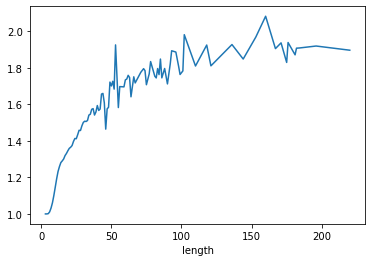

In [14]:
means.plot()

<AxesSubplot:xlabel='length'>

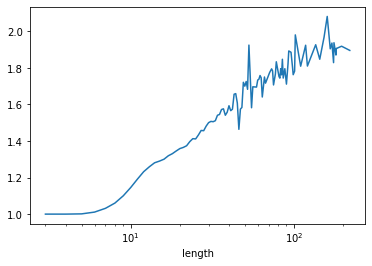

In [15]:
means.plot(logx=True)

In [6]:
counts = val.groupby(['length']).count()

<AxesSubplot:xlabel='length'>

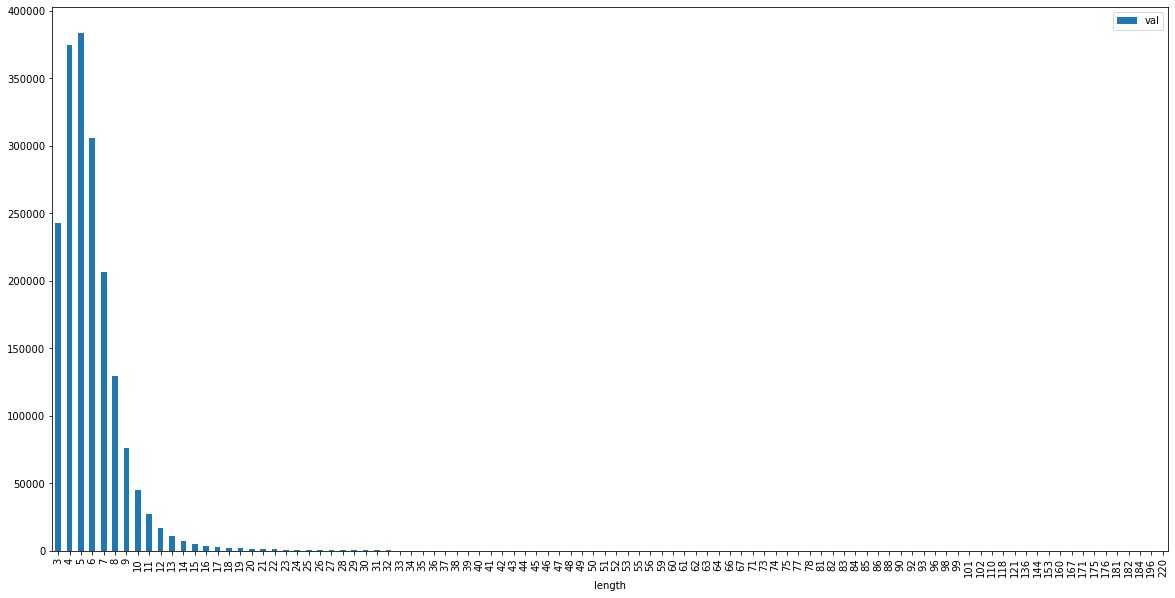

In [7]:
counts.plot(kind='bar',figsize=(20,10))

Linear regression as benchmark log(length) -> y

In [40]:
X = np.log2(val.length.values)[:,None]

In [8]:
length2weight = {k:1/v for k,v in counts.to_dict()['val'].items()}

In [9]:
weights = val.length.map(length2weight)

In [10]:
y = val.val.values

In [56]:
model = SGDRegressor(eta0=0.5)

In [57]:
model.fit(X,y,sample_weight=weights)

SGDRegressor(eta0=0.5)

In [58]:
yhat = model.predict(X)

In [60]:
np.sum(np.abs(y-yhat)*weights)/np.sum(weights)

0.0928318093993816

In [64]:
import matplotlib.pyplot as plt

(array([8.00000e+00, 1.60000e+01, 7.00000e+01, 7.40000e+01, 4.34000e+02,
        6.58000e+02, 4.34100e+03, 7.76700e+03, 2.00070e+04, 4.69580e+04,
        1.22900e+03, 1.00982e+05, 1.86488e+05, 2.99463e+05, 6.69400e+03,
        3.84761e+05, 1.16890e+04, 3.77193e+05, 2.21890e+04, 1.30500e+03,
        2.73690e+05, 1.28100e+03, 3.54170e+04, 1.19200e+03, 5.49400e+03,
        2.76980e+04, 2.36000e+03, 4.22600e+03, 5.96400e+03, 1.03390e+04,
        2.68200e+03, 8.14000e+02, 2.26000e+03, 6.51000e+02, 2.24900e+03,
        3.22000e+02, 2.47000e+02, 2.91000e+02, 1.91000e+02, 3.40000e+01,
        2.80000e+01, 9.70000e+01, 0.00000e+00, 3.00000e+00, 1.10000e+01,
        1.60000e+01, 0.00000e+00, 1.00000e+00, 0.00000e+00, 5.00000e+00]),
 array([-0.44470884, -0.42322479, -0.40174075, -0.3802567 , -0.35877265,
        -0.3372886 , -0.31580456, -0.29432051, -0.27283646, -0.25135242,
        -0.22986837, -0.20838432, -0.18690027, -0.16541623, -0.14393218,
        -0.12244813, -0.10096408, -0.07948004, -0

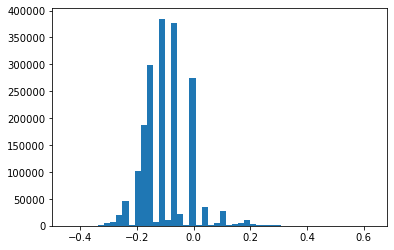

In [65]:
plt.hist(y-yhat,bins=50)

In [21]:
np.save('ys.npy',y.astype(np.float32))
np.save('weights.npy',weights.values.astype(np.float32))
np.save('length.npy',val.length.values.astype(np.float32))

In [15]:
indexes = [k for k,_ in mapping.items()]

In [23]:
with open('indexes.pkl', 'wb') as f:
    pickle.dump(indexes, f)

Data to train supervised baseline value function

In [2]:
import numpy as np
import torch
import pickle
from torch.utils.data import Dataset,DataLoader,WeightedRandomSampler

In [3]:
ys = np.load('ys.npy')
weights = np.load('weights.npy')
length = np.load('length.npy')
words_embed = np.load('possible_words_embed.npy')
with open('indexes.pkl', 'rb') as f:
    indexes = pickle.load( f)

In [29]:
# train/val split
train_idx = np.random.rand(ys.shape[0])>0.2
val_idx = np.logical_not(train_idx)

In [33]:
ys_train, ys_val = ys[train_idx], ys[val_idx]
weights_train, weights_val = weights[train_idx], weights[val_idx]
length_train, length_val = length[train_idx], length[val_idx]

indexes_train = [idx for idx,bol in zip(indexes,train_idx) if bol]
indexes_val = [idx for idx,bol in zip(indexes,train_idx) if not bol]

In [4]:
class CustomDataset(Dataset):
    def __init__(self, ys,length,indexes,words_embed):
        self.ys = ys
        self.length = length
        self.words_embed = words_embed
        self.indexes = indexes

    def __len__(self):
        return len(self.ys)

    def __getitem__(self, idx):
        return self.words_embed[np.array(self.indexes[idx])], self.length[idx] ,self.ys[idx]
    
def collate(batch):
    words,length,ys = zip(*batch)
    return torch.tensor(np.concatenate(words)).long(),torch.tensor(length),torch.tensor(ys)

In [5]:
data = CustomDataset(ys,length,indexes,words_embed)
sampler = WeightedRandomSampler(weights, 10000)
data = DataLoader(data, batch_size=32, sampler=sampler,collate_fn=collate)

In [6]:
#%debug
for words,length,ys in data:
    break

Model

In [1]:
import torch.nn as nn
from torch.nn import Embedding,Sequential, Linear, BatchNorm1d,Dropout,LeakyReLU
#from torch_scatter import segment_csr

In [7]:
words.shape

torch.Size([2395, 5])

In [8]:
length

tensor([  3.,  63.,  77.,  28., 118.,  98.,  85., 136.,  66.,  42., 144.,  75.,
         53.,  51., 176., 176., 153.,  48.,  32.,  56.,   6.,  29.,  25.,  32.,
        171.,  26., 118.,  13.,  17.,  50., 181.,  47.])

In [9]:
ys

tensor([1.0000, 1.7460, 1.7662, 1.3929, 1.9237, 1.8061, 1.8471, 1.9265, 1.7424,
        1.6667, 1.8472, 1.7067, 1.9245, 1.6471, 1.9375, 1.9375, 1.9673, 1.5833,
        1.4688, 1.6429, 1.0000, 1.6207, 1.3600, 1.2812, 1.9591, 1.4231, 1.9237,
        1.2308, 1.0000, 1.6000, 1.9061, 1.5745])

In [10]:
embed_size = 8

In [11]:
def MLP(in_d,out_d,multiple_factor=1,dropout=0.1):
    return Sequential(
                        Linear(in_d,in_d*multiple_factor),
                        LeakyReLU(inplace=True),
                        Dropout(dropout),
                        BatchNorm1d(in_d*multiple_factor),
                        Linear(in_d*multiple_factor,out_d),
                        LeakyReLU(inplace=True),
                        Dropout(dropout),
                        BatchNorm1d(out_d))

In [12]:
length_int = length.to(torch.long)

In [13]:
embed = torch.nn.Embedding(26, embed_size)

In [14]:
point = MLP(5*embed_size,5*embed_size)
group = MLP(5*embed_size,5*embed_size)
combine = Sequential(
                        Linear(5*embed_size*2,5*embed_size),
                        LeakyReLU(inplace=True),
                        Dropout(dropout),
                        BatchNorm1d(out_d))

In [15]:
in_ = embed(words).reshape(-1,5*embed_size)
len_long = torch.cat([torch.ones(l,dtype=torch.long,device=length_int.device)*i for i,l in enumerate(length_int)])

In [16]:
out = point(out)

In [31]:
# group = torch_scatter.segment_csr...
out_group = torch.randn(32,40)
out_group = group(out_group)

In [18]:
length_int#.sum()

tensor([  3,  63,  77,  28, 118,  98,  85, 136,  66,  42, 144,  75,  53,  51,
        176, 176, 153,  48,  32,  56,   6,  29,  25,  32, 171,  26, 118,  13,
         17,  50, 181,  47])

In [36]:
out = torch.cat([out,out_group[len_long]],1)

In [37]:
out = combine(out) + in_

torch.Size([2395, 80])